In [1]:
from sklearn.metrics import roc_auc_score# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
from sklearn.metrics import roc_auc_score, accuracy_score
# Any results you write to the current directory are saved as output.

['Playoffs.csv', 'playoff_win_loss.csv', 'regular_season.csv', 'regular_season', 'overwatch', 'Playoffs', 'regular_season_win_loss.csv']


In [2]:
import theano

def Logistic_Rating(rating):
    return 10.0**(rating/400)

def Expected(rating1, rating2):
    """
    These should be Logistic Ratings
    """
    log_rating1 = Logistic_Rating(rating1)
    log_rating2 = Logistic_Rating(rating2)
    return log_rating1/(log_rating1+log_rating2)

def Update_Rating(rating1, K, S, E):
    """
    rating1: rating should be the r
    K : Scaling factor between 1,99
    S : Outcome of game [0,1]
    E : Expected Outcome of the game
    """
    return rating1 + K*(S-E)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
regular_season = pd.read_csv('../input/regular_season_win_loss.csv')
regular_season.head()                             

,Win,Lose
0,Florida Mayhem,San Francisco Shock
1,San Francisco Shock,Florida Mayhem
2,San Francisco Shock,Florida Mayhem
3,San Francisco Shock,Florida Mayhem
4,Los Angeles Valiant,San Francisco Shock


In [4]:
teams = regular_season.Win.unique()
n_teams = len(teams)
teams = pd.DataFrame({"index":range(len(teams)), "team": teams})
teams.head(20)

,index,team
0,0,Florida Mayhem
1,1,San Francisco Shock
2,2,Los Angeles Valiant
3,3,Seoul Dynasty
4,4,Los Angeles Gladiators
5,5,London Spitfire
6,6,Dallas Fuel
7,7,Houston Outlaws
8,8,New York Excelsior
9,9,Boston Uprising


In [5]:
regular_season['Success']=1.0
wins=regular_season.groupby("Win").agg({"Success":'sum'})
wins = pd.merge(wins,\
                    teams.rename(index=str,\
                    columns={"team": "Win", "index": "win_index"}),
                    on = ['Win'] )
wins.head(20)

,Win,Success,win_index
0,Boston Uprising,98.0,9
1,Dallas Fuel,65.0,6
2,Florida Mayhem,43.0,0
3,Houston Outlaws,93.0,7
4,London Spitfire,108.0,5
5,Los Angeles Gladiators,99.0,4
6,Los Angeles Valiant,108.0,2
7,New York Excelsior,138.0,8
8,Philadelphia Fusion,94.0,11
9,San Francisco Shock,77.0,1


In [6]:
regular_season = pd.merge(regular_season,\
                    teams.rename(index=str,\
                    columns={"team": "Win", "index": "win_index"}),
                    on = ['Win'] )

regular_season = pd.merge(regular_season,\
                    teams.rename(index=str,\
                    columns={"team": "Lose", "index": "lose_index"}),
                    on = ['Lose'] )

regular_season = regular_season.drop(['Win','Lose'], axis=1)

regular_season.head()

,Success,win_index,lose_index
0,1.0,0,1
1,1.0,0,1
2,1.0,0,1
3,1.0,0,1
4,1.0,2,1


In [7]:
def build_training_df(df,add_losses=False):
    columns = ['win_index','lose_index','Success']
    df['Success'] = 1.0
    if add_losses:
            inverse_season = df.copy()
            inverse_season['tmp_lose_index'] = inverse_season['win_index']
            inverse_season['tmp_win_index'] = inverse_season['lose_index']

            inverse_season = inverse_season.drop(['win_index','lose_index'], axis=1)
            inverse_season = inverse_season.rename(index=str,\
                                columns={"tmp_win_index": "win_index", "tmp_lose_index": "lose_index"})
            inverse_season['Success'] = 0.0
            df=pd.concat([df[columns],inverse_season[columns]],axis=0)
    return df[columns]
    
X = build_training_df(regular_season)
X.head(1)

,win_index,lose_index,Success
0,0,1,1.0


In [8]:
import theano.tensor as T
print ("MAYBE FOR TRAINING, ONLY HAVE TRUTH VALUES")
winner_index = theano.shared(np.array(X['win_index']))
loser_index = theano.shared(np.array(X['lose_index']))
model_output = theano.shared(np.array(X['Success']))

MAYBE FOR TRAINING, ONLY HAVE TRUTH VALUES


In [9]:
import pymc3 as pm

print('Running on PyMC3 v{}'.format(pm.__version__))

elo = pm.Model()

with elo:
    sigma = pm.Gamma('noise', alpha=10.0, beta=1)
    #sigma = pm.Gamma('noise_worse', alpha=10.0, beta=2)
    #sigma = pm.HalfCauchy('noise', beta=3.0)
    elo_team = pm.Normal("elo_team", mu = 2000.0, sd=sigma, shape=n_teams)

    log_rating2 = 10.0**(elo_team[loser_index]/400.0)
    log_rating1 = 10.0**(elo_team[winner_index]/400.0)
    E = log_rating1/(log_rating1+log_rating2) # Expected value
    
    out = pm.Bernoulli('out', 
                   E,
                   observed=model_output)

Running on PyMC3 v3.6


In [10]:
use_advi = False

with elo:
    if use_advi:
        inference = pm.ADVI()
        advi_approx = pm.fit(n=100000, method=inference)
    else:
        trace = pm.sample(8000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [elo_team, noise]
Sampling 2 chains: 100%|██████████| 17000/17000 [00:47<00:00, 359.84draws/s]


In [11]:
#Now we sample from our approximation in order to get a similar trace
if use_advi:
    trace = advi_approx.sample(10000)

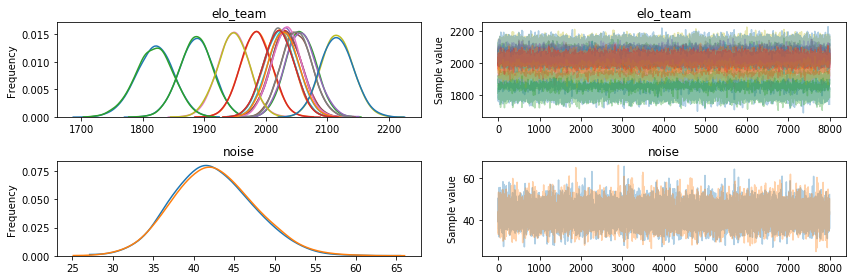

In [12]:
pm.traceplot(trace);

In [13]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
elo_team__0,1886.902479,26.804245,0.184216,1831.736686,1937.092529,20662.672671,1.000014
elo_team__1,1984.699994,24.998467,0.158736,1937.191351,2034.488071,22156.136093,0.999940
elo_team__2,2057.367130,24.865345,0.172443,2009.630549,2106.704445,21122.568430,0.999948
elo_team__3,2033.974774,24.876458,0.159948,1984.738341,2082.409690,21113.004346,0.999944
elo_team__4,2034.381207,24.340789,0.165470,1985.690940,2081.029477,20934.261489,0.999939
elo_team__5,2050.433952,24.615052,0.179117,2003.226981,2099.493394,18405.593489,0.999988
elo_team__6,1947.675731,25.370715,0.172229,1897.679568,1997.294231,22813.355967,0.999987
elo_team__7,2022.237612,24.625649,0.177086,1976.524021,2073.036065,20147.598004,0.999961
elo_team__8,2116.452494,26.094669,0.193487,2067.709716,2169.737281,17927.092693,0.999938
elo_team__9,2028.985198,24.840915,0.173867,1981.126049,2077.813210,20253.032906,1.000074


In [14]:
wins = wins.sort_values(by='win_index',ascending=True)
wins['Elo'] = trace.elo_team.mean(axis=0)
wins = wins.sort_values(by='Success',ascending=False)
wins.head(12)

,Win,Success,win_index,Elo
7,New York Excelsior,138.0,8,2116.452494
6,Los Angeles Valiant,108.0,2,2057.367130
4,London Spitfire,108.0,5,2050.433952
5,Los Angeles Gladiators,99.0,4,2034.381207
0,Boston Uprising,98.0,9,2028.985198
10,Seoul Dynasty,97.0,3,2033.974774
8,Philadelphia Fusion,94.0,11,2021.611648
3,Houston Outlaws,93.0,7,2022.237612
9,San Francisco Shock,77.0,1,1984.699994
1,Dallas Fuel,65.0,6,1947.675731


In [15]:
def make_preds(trace,model_name):
    ppc = pm.sample_posterior_predictive(trace, model=model_name, samples=500)
    return ppc['out'].mean(axis=0)

def scoreModel(trace,y,model_name):
    ppc = pm.sample_posterior_predictive(trace, model=model_name, samples=2000)
    pred = ppc['out'].mean(axis=0)
    #return roc_auc_score(y, pred)
    return accuracy_score(y,[round(x) for x in pred])

scoreModel(trace,X['Success'],elo)

100%|██████████| 2000/2000 [00:23<00:00, 84.04it/s]


0.6567593480345159

In [16]:
playoffs = pd.read_csv('../input/playoff_win_loss.csv')
playoffs.tail()

,Win,Lose
38,London Spitfire,Philadelphia Fusion
39,London Spitfire,Philadelphia Fusion
40,London Spitfire,Philadelphia Fusion
41,London Spitfire,Philadelphia Fusion
42,London Spitfire,Philadelphia Fusion


In [17]:
playoffs['Playoff_Success'] = 1.0
playoff_wins=playoffs.groupby("Win").agg({"Playoff_Success":'sum'})
playoff_wins.head(12)

,Playoff_Success
Win,
Boston Uprising,5.0
London Spitfire,18.0
Los Angeles Gladiators,3.0
Los Angeles Valiant,1.0
New York Excelsior,2.0
Philadelphia Fusion,14.0


In [18]:
"""
For our original batch of teams, only the top performing survived
into the playoff season. We have made the very naive assumption that
the best regular season teams would become the best post-season teams.

This has turned out to be only partially true. The teams with the most wins
in the regular season (Excelsior, Valiant, Gladiators) were quickly removed 
from the playoffs.

Teams with high ELO standings, but low wins, (Fusion) ultimately had 14 wins in the playoffs 
and ended up making it to 2nd place overall.
"""

wins = pd.merge(wins,playoff_wins, on=['Win'], how = 'left')
wins.head(20)

,Win,Success,win_index,Elo,Playoff_Success
0,New York Excelsior,138.0,8,2116.452494,2.0
1,Los Angeles Valiant,108.0,2,2057.367130,1.0
2,London Spitfire,108.0,5,2050.433952,18.0
3,Los Angeles Gladiators,99.0,4,2034.381207,3.0
4,Boston Uprising,98.0,9,2028.985198,5.0
5,Seoul Dynasty,97.0,3,2033.974774,NaN
6,Philadelphia Fusion,94.0,11,2021.611648,14.0
7,Houston Outlaws,93.0,7,2022.237612,NaN
8,San Francisco Shock,77.0,1,1984.699994,NaN
9,Dallas Fuel,65.0,6,1947.675731,NaN


In [19]:
playoffs = pd.merge(playoffs,\
                    teams.rename(index=str,\
                    columns={"team": "Win", "index": "win_index"}),
                    on = ['Win'] )

playoffs = pd.merge(playoffs,\
                    teams.rename(index=str,\
                    columns={"team": "Lose", "index": "lose_index"}),
                    on = ['Lose'] )

playoffs = playoffs.drop(['Win','Lose','Playoff_Success'], axis=1)

playoffs.head(5)

,win_index,lose_index
0,11,9
1,11,9
2,11,9
3,11,9
4,11,9


In [20]:
"""
THIS seems backwards. Bad teams are winning?
"""

for i in range(0,playoffs.count()[0],10):
    sample = playoffs.iloc[i:i+10]
    batch = build_training_df(sample,add_losses=True)
    batch = batch.sample(frac=1.0)
    winner_index.set_value(np.array(batch['win_index']))
    loser_index.set_value(np.array(batch['lose_index']))
    model_output.set_value(np.array(batch['Success']))
    
    print ("Batch AUC: ",i, scoreModel(trace,batch['Success'],elo) )
    batch['predictions']=make_preds(trace,elo)
    print (batch.head(20))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
  2%|▏         | 11/500 [00:00<00:04, 101.86it/s]

Batch AUC:  0 0.1


  1%|          | 11/2000 [00:00<00:19, 100.76it/s]

   win_index  lose_index  Success  predictions
0         11           9      1.0        0.508
6          9          11      0.0        0.534
6         11           9      1.0        0.454
5         11           9      1.0        0.524
9         11           8      1.0        0.394
3         11           9      1.0        0.438
8          8          11      0.0        0.624
9          8          11      0.0        0.642
4          9          11      0.0        0.514
5          9          11      0.0        0.496
7          8          11      0.0        0.586
7         11           8      1.0        0.342
2         11           9      1.0        0.450
1          9          11      0.0        0.484
1         11           9      1.0        0.490
4         11           9      1.0        0.484
0          9          11      0.0        0.558
2          9          11      0.0        0.476
3          9          11      0.0        0.518
8         11           8      1.0        0.344


  2%|▏         | 11/500 [00:00<00:04, 105.62it/s]

Batch AUC:  10 0.15


  1%|          | 11/2000 [00:00<00:19, 102.88it/s]

    win_index  lose_index  Success  predictions
11          8          11      0.0        0.612
12          8          11      0.0        0.626
15          4           5      1.0        0.428
14          5           4      0.0        0.526
18          9          11      1.0        0.522
19          9          11      1.0        0.488
10          8          11      0.0        0.676
18         11           9      0.0        0.504
15          5           4      0.0        0.532
16          5           4      0.0        0.512
19         11           9      0.0        0.498
16          4           5      1.0        0.490
17          5           2      0.0        0.502
12         11           8      1.0        0.350
14          4           5      1.0        0.508
11         11           8      1.0        0.384
17          2           5      1.0        0.524
13         11           5      1.0        0.462
10         11           8      1.0        0.360
13          5          11      0.0      

  2%|▏         | 11/500 [00:00<00:04, 107.08it/s]

Batch AUC:  20 0.95


  0%|          | 10/2000 [00:00<00:20, 97.51it/s]

    win_index  lose_index  Success  predictions
22         11           9      0.0        0.446
27          5          11      1.0        0.560
21          9          11      1.0        0.484
28         11           5      0.0        0.446
29         11           8      0.0        0.350
21         11           9      0.0        0.496
28          5          11      1.0        0.534
22          9          11      1.0        0.486
25          5          11      1.0        0.536
20         11           9      0.0        0.482
24         11           5      0.0        0.430
20          9          11      1.0        0.494
23         11           5      0.0        0.438
23          5          11      1.0        0.564
27         11           5      0.0        0.486
29          8          11      1.0        0.678
24          5          11      1.0        0.548
25         11           5      0.0        0.476
26          5          11      1.0        0.546
26         11           5      0.0      

  2%|▏         | 10/500 [00:00<00:04, 99.06it/s]

Batch AUC:  30 0.75


  1%|          | 11/2000 [00:00<00:19, 102.96it/s]

    win_index  lose_index  Success  predictions
30         11           8      0.0        0.388
33          5           4      1.0        0.512
31          4           5      0.0        0.462
37          2           5      0.0        0.538
35          5           4      1.0        0.524
39          2           5      0.0        0.538
36          5           4      1.0        0.494
34          4           5      0.0        0.462
31          5           4      1.0        0.538
38          2           5      0.0        0.492
37          5           2      1.0        0.462
36          4           5      0.0        0.486
32          4           5      0.0        0.472
33          4           5      0.0        0.458
35          4           5      0.0        0.496
38          5           2      1.0        0.490
34          5           4      1.0        0.524
30          8          11      1.0        0.630
39          5           2      1.0        0.470
32          5           4      1.0      

  2%|▏         | 11/500 [00:00<00:04, 107.23it/s]

Batch AUC:  40 0.16666666666666666


100%|██████████| 500/500 [00:05<00:00, 93.68it/s]

    win_index  lose_index  Success  predictions
40          2           5      0.0        0.486
42          2           5      0.0        0.498
41          2           5      0.0        0.526
42          5           2      1.0        0.492
41          5           2      1.0        0.480
40          5           2      1.0        0.488


In [21]:
X_test = build_training_df(playoffs,add_losses=True)
winner_index.set_value(np.array(X_test['win_index']))
loser_index.set_value(np.array(X_test['lose_index']))
model_output.set_value(np.array(X_test['Success']))
X_test['preds'] = make_preds(trace,elo)
X_test['prediction'] = [round(x) for x in X_test['preds'].values ]

100%|██████████| 500/500 [00:05<00:00, 90.44it/s] 


In [22]:
accuracy_score(X_test['Success'], X_test['prediction'])

0.5116279069767442

In [23]:
X_test.tail()

,win_index,lose_index,Success,preds,prediction
38,2,5,0.0,0.522,1.0
39,2,5,0.0,0.498,0.0
40,2,5,0.0,0.520,1.0
41,2,5,0.0,0.496,0.0
42,2,5,0.0,0.492,0.0


In [24]:
X_test = pd.merge(X_test,\
                    wins[['win_index','Elo']],
                    on = ['win_index'],how='inner')
X_test = X_test.rename(index=str,\
                    columns={"Elo": "Elo_Win"})

X_test = pd.merge(X_test,\
                    wins[['win_index','Elo']].rename(index=str,\
                       columns={"win_index": "lose_index"}),
                    on = ['lose_index'],how='inner')
X_test = X_test.rename(index=str,\
                    columns={"Elo": "Elo_Lose"})
X_test.tail()

,win_index,lose_index,Success,preds,prediction,Elo_Win,Elo_Lose
81,5,2,1.0,0.464,0.0,2050.433952,2057.36713
82,5,2,1.0,0.452,0.0,2050.433952,2057.36713
83,5,2,1.0,0.506,1.0,2050.433952,2057.36713
84,5,2,1.0,0.478,0.0,2050.433952,2057.36713
85,5,2,0.0,0.478,0.0,2050.433952,2057.36713


In [25]:
X_test['raw_expected'] = Expected(X_test['Elo_Win'],X_test['Elo_Lose'])
X_test.tail()

,win_index,lose_index,Success,preds,prediction,Elo_Win,Elo_Lose,raw_expected
81,5,2,1.0,0.464,0.0,2050.433952,2057.36713,0.490024
82,5,2,1.0,0.452,0.0,2050.433952,2057.36713,0.490024
83,5,2,1.0,0.506,1.0,2050.433952,2057.36713,0.490024
84,5,2,1.0,0.478,0.0,2050.433952,2057.36713,0.490024
85,5,2,0.0,0.478,0.0,2050.433952,2057.36713,0.490024


In [26]:
roc_auc_score(X_test['Success'], X_test['raw_expected'])

0.5154137371552191